# Tree Ensembles

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 3
NUM_TREES = 300

In [2]:
import numpy as np
import pandas as pd
import time
import math
import os
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Scoring Function

In [3]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        try:
            model.fit(X_train, y_train, sample_weight = train_weight)
        except:
            model.fit(X_train, y_train)
        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Plot confusion matrix
def plot_confusion_matrix(true_values, pred_values, gcds, sample_weight = None, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,10))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            if sample_weight is not None:
                cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]], sample_weight = sample_weight[gcds == gcd[row][col]])
                acc = accuracy_score(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]], sample_weight = sample_weight[gcds == gcd[row][col]])
            else:
                cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
                acc = accuracy_score(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
            ax[row,col].set_title(f'GCD = {gcd[row][col]}, Accuracy: {round(acc, 5)}')
    plt.show()

# Load Data

In [5]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]

encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
target_bins = train['target'].astype(str) + train['gcd'].astype(str)

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1.12 s
Wall time: 282 ms


# Sklearn Tree Ensembles

In [6]:
# Base Estimators
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

## 1. AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostClassifier


Fold 0: 0.79549 accuracy in 13.49s.
Fold 1: 0.79448 accuracy in 13.76s.
Fold 2: 0.79975 accuracy in 13.04s.

Accuracy (1M Reads): 0.99892
Accuracy (100k Reads): 0.96698
Accuracy (1k Reads): 0.6076
Accuracy (100 Reads): 0.61304
Out-of-Fold Accuracy: 0.79658
Training Time: 40.29s


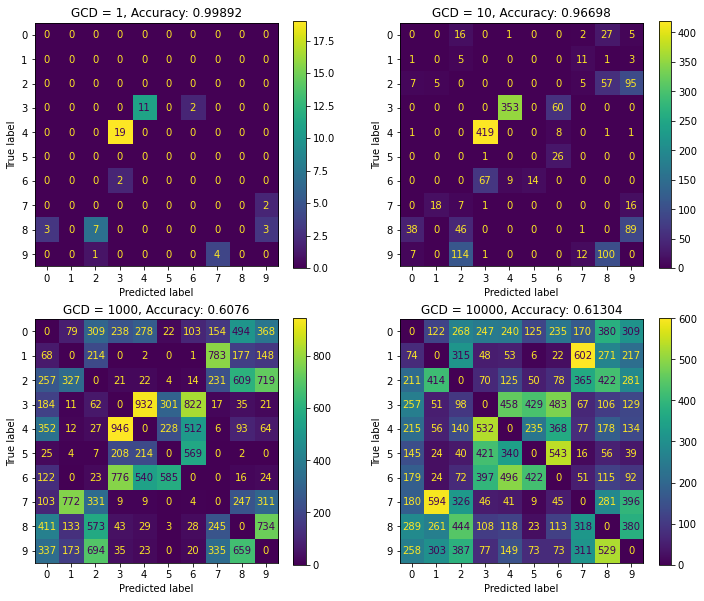

In [8]:
# Base Estimator - Default DecisionTree
oof_preds = score_model(
    AdaBoostClassifier(
        DecisionTreeClassifier(),
        n_estimators = NUM_TREES,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 2. Bagging Classifier

In [9]:
from sklearn.ensemble import BaggingClassifier


Fold 0: 0.87248 accuracy in 16.23s.
Fold 1: 0.87028 accuracy in 16.67s.
Fold 2: 0.87515 accuracy in 14.65s.

Accuracy (1M Reads): 0.99978
Accuracy (100k Reads): 0.99402
Accuracy (1k Reads): 0.75271
Accuracy (100 Reads): 0.74417
Out-of-Fold Accuracy: 0.87264
Training Time: 47.55s


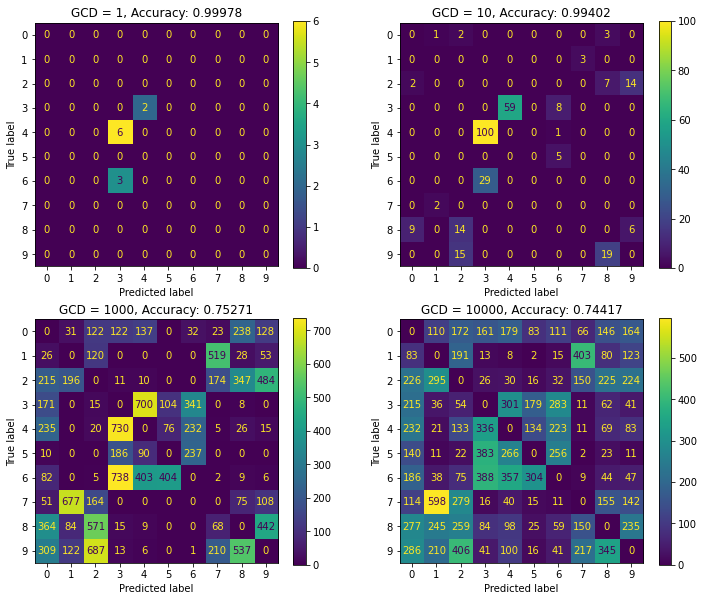

In [10]:
oof_preds = score_model(
    BaggingClassifier(
        random_state = RANDOM_SEED,
        n_jobs = -1,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 3. Extra Trees

In [11]:
from sklearn.ensemble import ExtraTreesClassifier


Fold 0: 0.94643 accuracy in 15.77s.
Fold 1: 0.9509 accuracy in 16.22s.
Fold 2: 0.94634 accuracy in 17.8s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.90663
Accuracy (100 Reads): 0.88499
Out-of-Fold Accuracy: 0.9479
Training Time: 49.79s


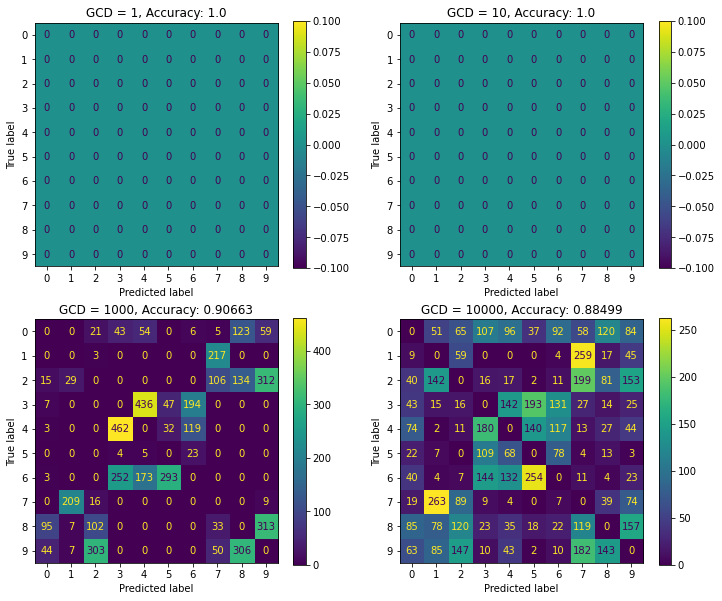

In [12]:
oof_preds = score_model(
    ExtraTreesClassifier(
        n_jobs = -1, 
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 3a. AdaBoost w/ ExtraTrees


Fold 0: 0.94906 accuracy in 15.62s.
Fold 1: 0.94936 accuracy in 24.21s.
Fold 2: 0.94741 accuracy in 17.23s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.90998
Accuracy (100 Reads): 0.88449
Out-of-Fold Accuracy: 0.94861
Training Time: 57.05s


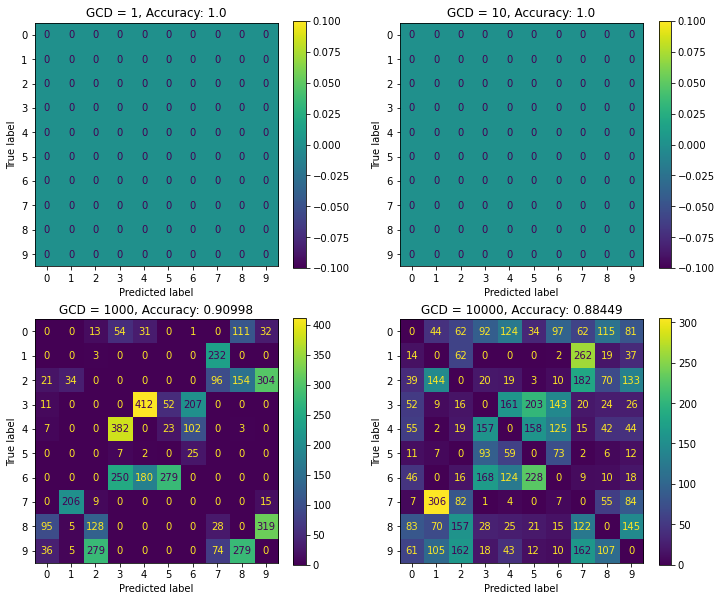

In [13]:
# Base Estimator - Default DecisionTree
oof_preds = score_model(
    AdaBoostClassifier(
        ExtraTreesClassifier(
            n_jobs = -1, 
            n_estimators = NUM_TREES,
            random_state = RANDOM_SEED,
        ),
        n_estimators = 10,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 3b. Bagging w/ ExtraTrees


Fold 0: 0.95177 accuracy in 174.53s.
Fold 1: 0.95447 accuracy in 175.34s.
Fold 2: 0.95264 accuracy in 166.44s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92551
Accuracy (100 Reads): 0.88635
Out-of-Fold Accuracy: 0.95296
Training Time: 516.31s


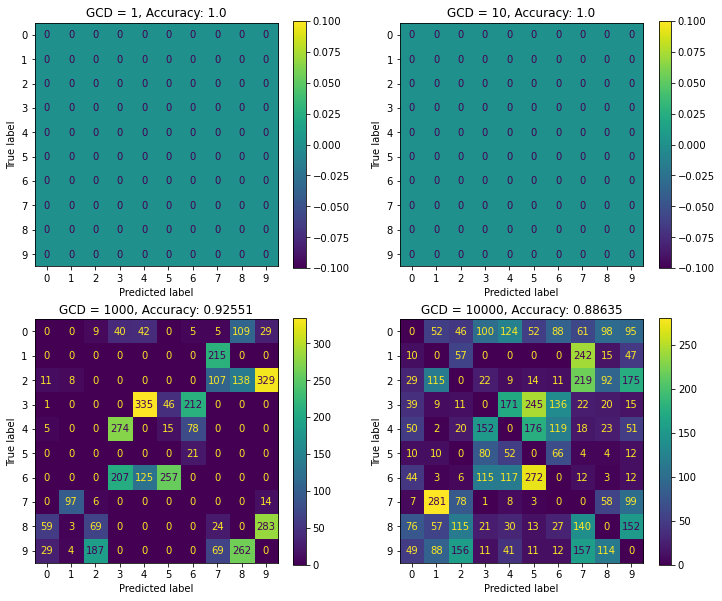

In [14]:
oof_preds = score_model(
    BaggingClassifier(
        ExtraTreesClassifier(
            n_jobs = -1, 
            n_estimators = NUM_TREES,
            random_state = RANDOM_SEED,
        ),
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 4. Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier


Fold 0: 0.94654 accuracy in 16.62s.
Fold 1: 0.94812 accuracy in 15.78s.
Fold 2: 0.94751 accuracy in 16.52s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99994
Accuracy (1k Reads): 0.91454
Accuracy (100 Reads): 0.87511
Out-of-Fold Accuracy: 0.94739
Training Time: 48.91s


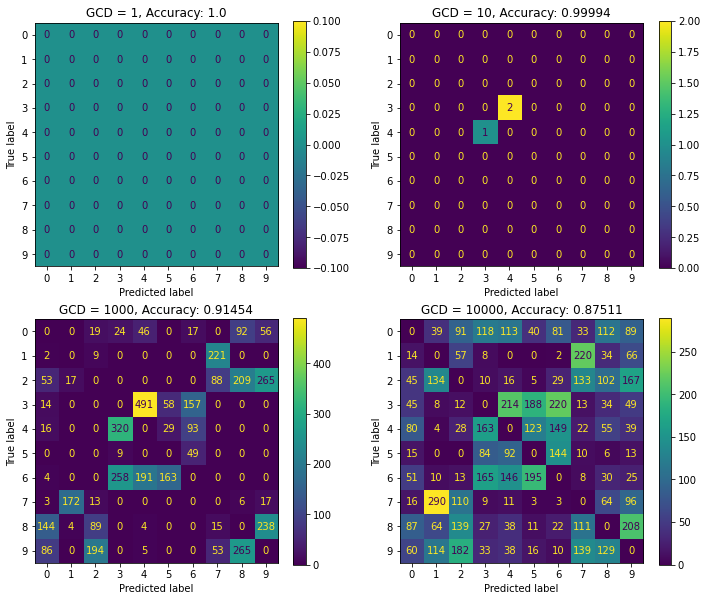

In [16]:
oof_preds = score_model(
    RandomForestClassifier(
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
        n_jobs = -1,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 4a. Adaboost w/ Random Forest


Fold 0: 0.94439 accuracy in 19.0s.
Fold 1: 0.94751 accuracy in 19.66s.
Fold 2: 0.94463 accuracy in 20.17s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99998
Accuracy (1k Reads): 0.90801
Accuracy (100 Reads): 0.87409
Out-of-Fold Accuracy: 0.94551
Training Time: 58.83s


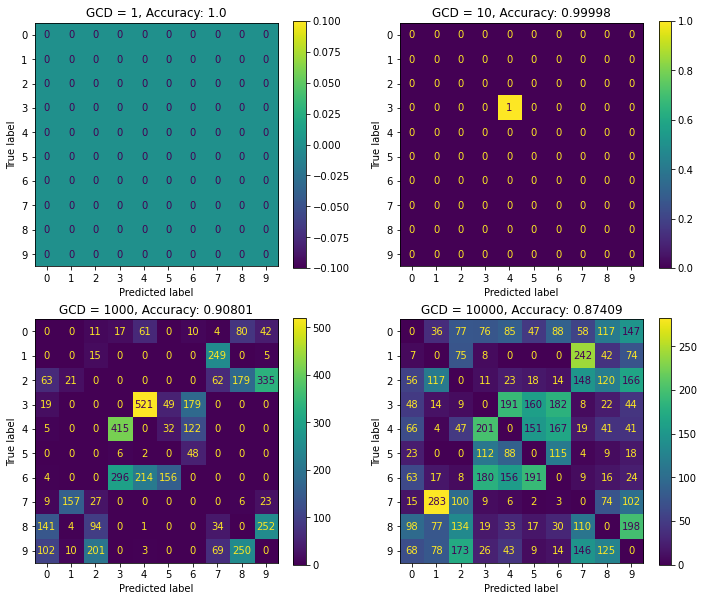

In [17]:
# Base Estimator - Default DecisionTree
oof_preds = score_model(
    AdaBoostClassifier(
        RandomForestClassifier(
            n_jobs = -1, 
            n_estimators = NUM_TREES,
            random_state = RANDOM_SEED,
        ),
        n_estimators = 10,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 4b. Bagging w/ Random Forest


Fold 0: 0.94966 accuracy in 139.72s.
Fold 1: 0.95105 accuracy in 132.32s.
Fold 2: 0.94934 accuracy in 136.65s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99998
Accuracy (1k Reads): 0.92317
Accuracy (100 Reads): 0.87695
Out-of-Fold Accuracy: 0.95002
Training Time: 408.69s


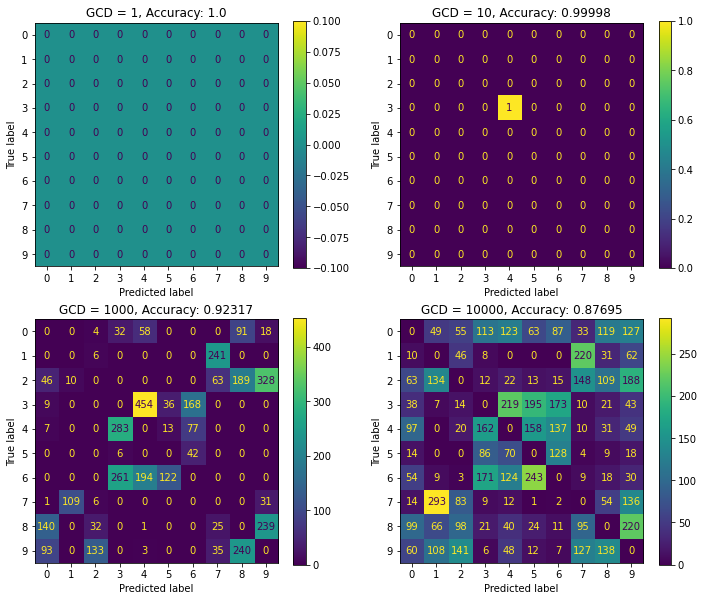

In [18]:
oof_preds = score_model(
    BaggingClassifier(
        RandomForestClassifier(
            n_jobs = -1, 
            n_estimators = NUM_TREES,
            random_state = RANDOM_SEED,
        ),
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 5. Gradient Boosting

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier


Fold 0: 0.94597 accuracy in 244.68s.
Fold 1: 0.94884 accuracy in 219.24s.
Fold 2: 0.94693 accuracy in 233.22s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99988
Accuracy (1k Reads): 0.91804
Accuracy (100 Reads): 0.87109
Out-of-Fold Accuracy: 0.94724
Training Time: 697.14s


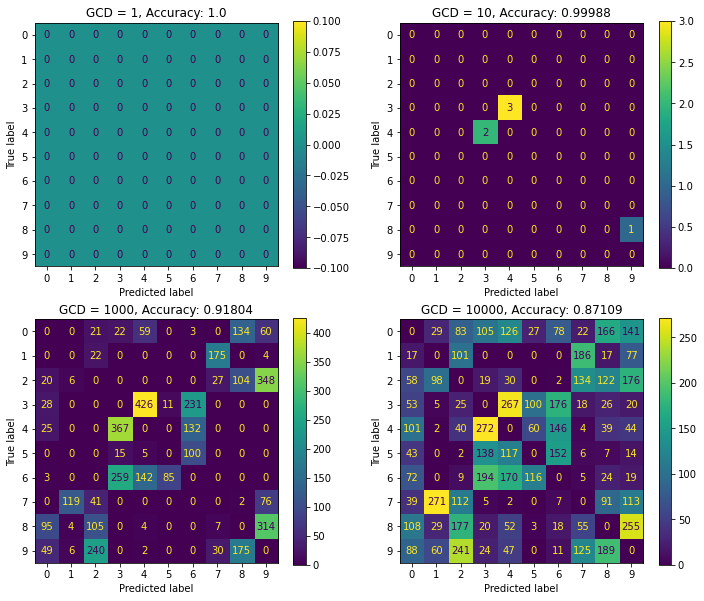

In [20]:
oof_preds = score_model(
    HistGradientBoostingClassifier(        
        max_iter = NUM_TREES,
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# XGBoost

In [21]:
from xgboost import XGBClassifier


Fold 0: 0.94721 accuracy in 341.96s.
Fold 1: 0.95066 accuracy in 339.45s.
Fold 2: 0.94729 accuracy in 329.31s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99986
Accuracy (1k Reads): 0.91825
Accuracy (100 Reads): 0.87547
Out-of-Fold Accuracy: 0.94839
Training Time: 1010.72s


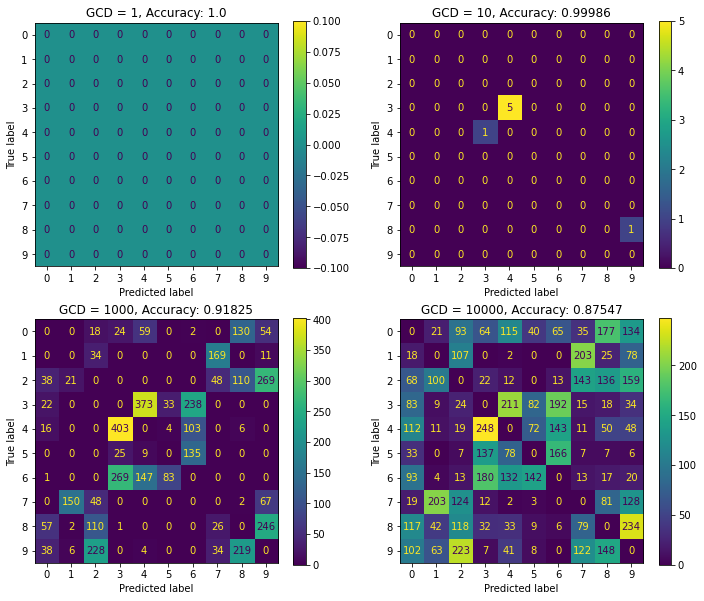

In [22]:
oof_preds = score_model(
    XGBClassifier(
        eval_metric = 'mlogloss',
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
        n_jobs = -1,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# LightGBM

In [23]:
from lightgbm import LGBMClassifier


Fold 0: 0.94947 accuracy in 62.58s.
Fold 1: 0.95173 accuracy in 62.78s.
Fold 2: 0.95021 accuracy in 65.87s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99982
Accuracy (1k Reads): 0.92157
Accuracy (100 Reads): 0.88051
Out-of-Fold Accuracy: 0.95047
Training Time: 191.23s


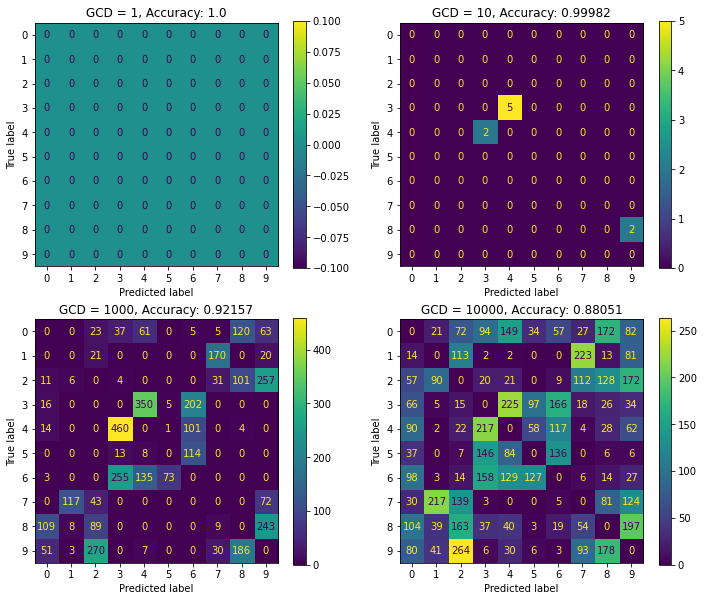

In [24]:
oof_preds = score_model(
    LGBMClassifier(       
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# CatBoost

In [25]:
from catboost import CatBoostClassifier


Fold 0: 0.91421 accuracy in 228.34s.
Fold 1: 0.91358 accuracy in 224.64s.
Fold 2: 0.9145 accuracy in 223.16s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99736
Accuracy (1k Reads): 0.86116
Accuracy (100 Reads): 0.7979
Out-of-Fold Accuracy: 0.9141
Training Time: 676.14s


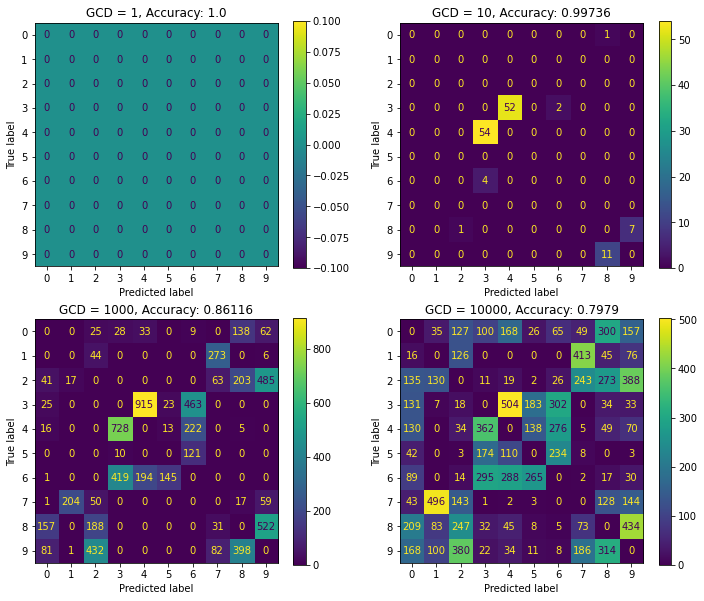

In [26]:
oof_preds = score_model(
    CatBoostClassifier(        
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
        verbose = False
    )
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])